[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmedlone127/Multilingual_Sentiment/blob/master/Colab/multilingual_sentiment.ipynb) 
##1. Install Spark NLP 

In [ ]:
! wget http://setup.johnsnowlabs.com/colab.sh -O - | bash
import sparknlp
spark = sparknlp.start(gpu = True)
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

--2021-12-08 17:22:18--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-12-08 17:22:19--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-12-08 17:22:19--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

##2. Load Data

In [ ]:
!wget https://raw.githubusercontent.com/ahmedlone127/Multilingual_Sentiment/master/Data/Sentiment_Test.csv
!wget https://raw.githubusercontent.com/ahmedlone127/Multilingual_Sentiment/master/Data/Sentiment_Train.csv
import pandas as pd 
df = pd.read_csv("Sentiment_Train.csv")
train_df = spark.createDataFrame(df)
df = pd.read_csv("Sentiment_Test.csv")
df = df.iloc[:7000]
test_df = spark.createDataFrame(df)
train_df.show()

--2021-12-08 15:53:47--  https://raw.githubusercontent.com/ahmedlone127/Multilingual_Sentiment/master/Data/Sentiment_Test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1031534 (1007K) [text/plain]
Saving to: ‘Sentiment_Test.csv’

Sentiment_Test.csv  100%[===================>]   1007K  --.-KB/s    in 0.05s   

2021-12-08 15:53:47 (20.1 MB/s) - ‘Sentiment_Test.csv’ saved [1031534/1031534]

--2021-12-08 15:53:47--  https://raw.githubusercontent.com/ahmedlone127/Multilingual_Sentiment/master/Data/Sentiment_Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, 

##2.5 Define plotting Utils 

In [ ]:
import matplotlib.pyplot as plt
def loss_plot(log_path) :
    with open(log_path, "r", encoding="utf-8") as f :
        lines = f.readlines()

    loss = [line.split()[6] for line in lines if line.startswith("Epoch") and line.split()[6] != "size:"]

    
    epoch = []
    losses = []
    for x, y in enumerate(loss, 1):
        epoch.append(x)
        losses.append(float(y))
    plt.subplots(1,1, figsize=(8,8))
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.plot(epoch[::-1], losses[::-1])
    plt.show()

def acc_plot(log_path):
    with open(log_path, "r", encoding="utf-8") as f :
        lines = f.readlines()

    loss = [line.split()[9] for line in lines if line.startswith("Epoch") and line.split()[6] != "size:"]

    
    epoch = []
    losses = []
    for x, y in enumerate(loss, 1):
        epoch.append(x)
        losses.append(float(y))
    plt.subplots(1,1, figsize=(8,8))
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title('Accuracy Plot')
    plt.plot(epoch[::-1], losses[::-1])
    plt.show()


##3. Train Model with Bert

In [ ]:
!mkdir classifier_logs_Bert


In [ ]:
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *


document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
sent_embeddings = BertSentenceEmbeddings.pretrained("sent_bert_use_cmlm_multi_base_br", "xx") \
      .setInputCols("document") \
      .setOutputCol("sentence_embeddings")
classifierDl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("y")\
  .setMaxEpochs(125)\
  .setLr(0.0007)  \
  .setEnableOutputLogs(True)\
  .setOutputLogsPath('classifier_logs_Bert')

pipeline = Pipeline(
    stages = [
        document,
        sent_embeddings,
        classifierDl
    ])

mutli_lingual_model = pipeline.fit(train_df)


sent_bert_use_cmlm_multi_base_br download started this may take some time.
Approximate size to download 1.7 GB
[OK!]


In [ ]:
import os

log_files = os.listdir("/content/classifier_logs_Bert")
log_files

['ClassifierDLApproach_0a598a33b9ec.log']

In [ ]:
with open("/content/classifier_logs_Bert/"+log_files[0]) as log_file:
    print(log_file.read())

Training started - epochs: 125 - learning_rate: 7.0E-4 - batch_size: 64 - training_examples: 40000 - classes: 2
Epoch 0/125 - 3.10s - loss: 304.901 - acc: 0.82385 - batches: 625
Epoch 1/125 - 2.38s - loss: 287.4698 - acc: 0.8568 - batches: 625
Epoch 2/125 - 2.52s - loss: 282.4568 - acc: 0.86515 - batches: 625
Epoch 3/125 - 2.30s - loss: 279.53622 - acc: 0.870625 - batches: 625
Epoch 4/125 - 2.31s - loss: 277.23898 - acc: 0.874325 - batches: 625
Epoch 5/125 - 2.37s - loss: 275.39587 - acc: 0.87735 - batches: 625
Epoch 6/125 - 2.33s - loss: 273.97437 - acc: 0.8804 - batches: 625
Epoch 7/125 - 2.31s - loss: 272.88947 - acc: 0.88245 - batches: 625
Epoch 8/125 - 2.33s - loss: 272.02692 - acc: 0.884525 - batches: 625
Epoch 9/125 - 2.41s - loss: 271.30258 - acc: 0.88605 - batches: 625
Epoch 10/125 - 2.30s - loss: 270.67545 - acc: 0.887375 - batches: 625
Epoch 11/125 - 2.31s - loss: 270.12384 - acc: 0.888625 - batches: 625
Epoch 12/125 - 2.33s - loss: 269.6141 - acc: 0.88965 - batches: 625
Epo

## 3.5 Plot Bert Accuracy and Loss

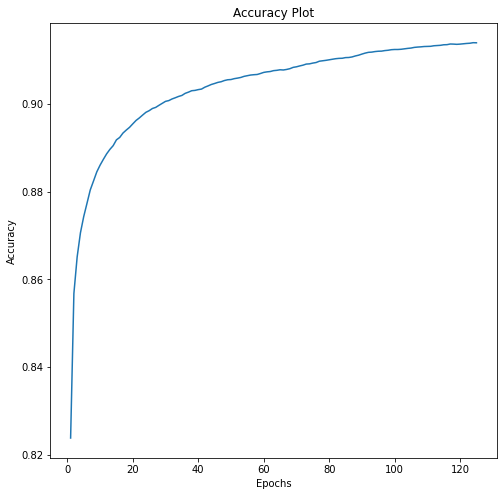

In [ ]:
acc_plot("/content/classifier_logs_Bert/"+log_files[0])

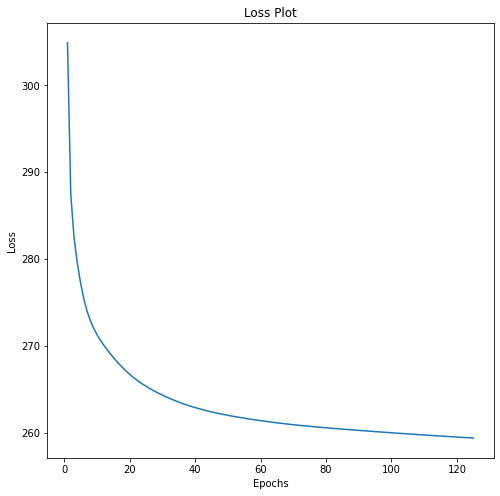

In [ ]:
loss_plot("/content/classifier_logs_Bert/"+log_files[0])

##5. Evaluate Trained Model on Test Data

In [ ]:
preds = mutli_lingual_model.transform(test_df)
preds.show()

+------+---------------------------------+--------+--------------------+--------------------+--------------------+
|   _c0|                             text|       y|            document| sentence_embeddings|               class|
+------+---------------------------------+--------+--------------------+--------------------+--------------------+
|800000|케빈의 연기력도 허접한 감독의 ...|negative|[[document, 0, 30...|[[sentence_embedd...|[[category, 0, 30...|
|800001|            roki79@nate.com 기...|positive|[[document, 0, 64...|[[sentence_embedd...|[[category, 0, 64...|
|800002|             Se aprendem a faz...|positive|[[document, 0, 19...|[[sentence_embedd...|[[category, 0, 19...|
|800003|             @little_bluebit n...|negative|[[document, 0, 71...|[[sentence_embedd...|[[category, 0, 71...|
|800004|             Quem se sente inc...|positive|[[document, 0, 37...|[[sentence_embedd...|[[category, 0, 37...|
|800005|             eheheh hoje vou e...|positive|[[document, 0, 69...|[[sentence_embedd...|[

In [ ]:
df = preds.select(['y','class.result']).toPandas()
df['result'] = df['result'].apply(lambda x : x[0])
df

,y,result
0,negative,positive
1,positive,positive
2,positive,positive
3,negative,negative
4,positive,positive
...,...,...
6995,negative,positive
6996,negative,negative
6997,positive,negative
6998,positive,positive


In [ ]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report
print(classification_report(df['result'], df['y']))

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      3496
    positive       0.85      0.85      0.85      3504

    accuracy                           0.85      7000
   macro avg       0.85      0.85      0.85      7000
weighted avg       0.85      0.85      0.85      7000



In [ ]:
from sklearn.metrics import f1_score,precision_score,accuracy_score
Bert_f1= f1_score(df['result'], df['y'], average='macro')
Bert_f1_precision = precision_score(df['result'], df['y'], average='macro')
print(Bert_f1, Bert_f1_precision)

0.8522857142857143 0.8522868274766726


##6. Train Model with DistilBERT 

In [ ]:
!mkdir classifier_logs_DistilBERT 


In [ ]:
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *


document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
embeddings  = DistilBertEmbeddings.pretrained("distilbert_base_multilingual_cased", "xx") \
      .setInputCols("document", "token") \
      .setOutputCol("embeddings")
tokenizer = Tokenizer() \
      .setInputCols(["document"]) \
      .setOutputCol("token")
classifierDl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("y")\
  .setMaxEpochs(125)\
  .setLr(0.0007)  \
  .setEnableOutputLogs(True)\
  .setOutputLogsPath('classifier_logs_DistilBERT')
embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")
pipeline = Pipeline(
    stages = [
        document,
        tokenizer,
        embeddings ,
        embeddingsSentence,
        classifierDl
    ])

mutli_lingual_model_Distil_Bert = pipeline.fit(train_df)


distilbert_base_multilingual_cased download started this may take some time.
Approximate size to download 482 MB
[OK!]


In [ ]:
import os

log_files = os.listdir("/content/classifier_logs_DistilBERT")
log_files

['ClassifierDLApproach_47715179e492.log']

In [ ]:
with open("/content/classifier_logs_DistilBERT/"+log_files[0]) as log_file:
    print(log_file.read())

Training started - epochs: 125 - learning_rate: 7.0E-4 - batch_size: 64 - training_examples: 40000 - classes: 2
Epoch 0/125 - 2.79s - loss: 385.89658 - acc: 0.64955 - batches: 625
Epoch 1/125 - 2.56s - loss: 367.54022 - acc: 0.68365 - batches: 625
Epoch 2/125 - 2.61s - loss: 362.5617 - acc: 0.694475 - batches: 625
Epoch 3/125 - 2.45s - loss: 359.78 - acc: 0.70155 - batches: 625
Epoch 4/125 - 2.36s - loss: 357.6727 - acc: 0.70645 - batches: 625
Epoch 5/125 - 2.36s - loss: 356.02975 - acc: 0.70965 - batches: 625
Epoch 6/125 - 2.31s - loss: 354.62772 - acc: 0.71315 - batches: 625
Epoch 7/125 - 2.31s - loss: 353.43567 - acc: 0.715725 - batches: 625
Epoch 8/125 - 2.34s - loss: 352.4083 - acc: 0.7182 - batches: 625
Epoch 9/125 - 2.30s - loss: 351.51413 - acc: 0.7204 - batches: 625
Epoch 10/125 - 2.31s - loss: 350.7243 - acc: 0.72265 - batches: 625
Epoch 11/125 - 2.26s - loss: 350.00702 - acc: 0.72385 - batches: 625
Epoch 12/125 - 2.27s - loss: 349.32724 - acc: 0.72555 - batches: 625
Epoch 13

## 6.5 Plot DistilBERT Accuracy and Loss

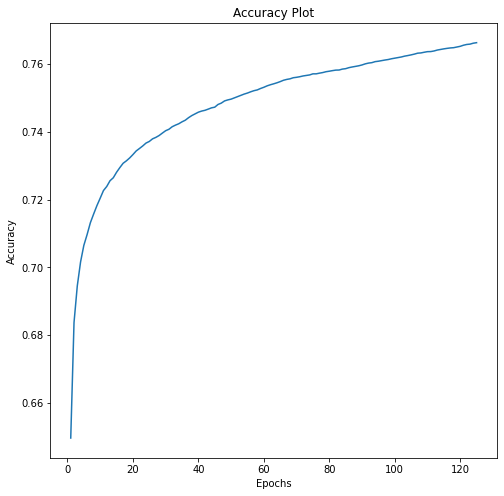

In [ ]:
acc_plot("/content/classifier_logs_DistilBERT/"+log_files[0])

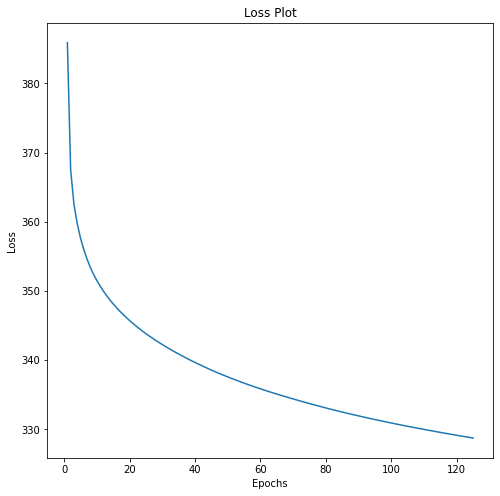

In [ ]:
loss_plot("/content/classifier_logs_DistilBERT/"+log_files[0])

##7. Evaluate Trained Model on Test Data

In [ ]:
preds = mutli_lingual_model_Distil_Bert.transform(test_df)
preds.show()

+------+---------------------------------+--------+--------------------+----------------------+--------------------+--------------------+--------------------+
|   _c0|                             text|       y|            document|                 token|          embeddings| sentence_embeddings|               class|
+------+---------------------------------+--------+--------------------+----------------------+--------------------+--------------------+--------------------+
|800000|케빈의 연기력도 허접한 감독의 ...|negative|[[document, 0, 30...|[[token, 0, 2, 케빈...|[[word_embeddings...|[[sentence_embedd...|[[category, 0, 30...|
|800001|            roki79@nate.com 기...|positive|[[document, 0, 64...|  [[token, 0, 14, r...|[[word_embeddings...|[[sentence_embedd...|[[category, 0, 64...|
|800002|             Se aprendem a faz...|positive|[[document, 0, 19...|  [[token, 0, 1, Se...|[[word_embeddings...|[[sentence_embedd...|[[category, 0, 19...|
|800003|             @little_bluebit n...|negative|[[document,

In [ ]:
df = preds.select(['y','class.result']).toPandas()
df['result'] = df['result'].apply(lambda x : x[0])
df

,y,result
0,negative,positive
1,positive,negative
2,positive,positive
3,negative,negative
4,positive,negative
...,...,...
6995,negative,positive
6996,negative,negative
6997,positive,positive
6998,positive,positive


In [ ]:

# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report
print(classification_report(df['result'], df['y']))

              precision    recall  f1-score   support

    negative       0.72      0.69      0.71      3654
    positive       0.68      0.71      0.70      3346

    accuracy                           0.70      7000
   macro avg       0.70      0.70      0.70      7000
weighted avg       0.70      0.70      0.70      7000



In [ ]:
from sklearn.metrics import f1_score,precision_score,accuracy_score
DistilBERT_f1= f1_score(df['result'], df['y'], average='macro')
DistilBERT_f1_precision = precision_score(df['result'], df['y'], average='macro')
print(DistilBERT_f1, DistilBERT_f1_precision)

0.7018481007344232 0.7019751209470968


##8. Train Model with XLM-Roberta

In [ ]:
!mkdir classifier_logs_XLM_Roberta


In [ ]:
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *


document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
sent_embeddings =  XlmRoBertaSentenceEmbeddings.pretrained("sent_xlm_roberta_base", "xx") \
      .setInputCols("document") \
      .setOutputCol("sentence_embeddings")
classifierDl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("y")\
  .setMaxEpochs(125)\
  .setLr(0.0007)  \
  .setEnableOutputLogs(True)\
  .setOutputLogsPath('classifier_logs_XLM_Roberta')

pipeline = Pipeline(
    stages = [
        document,
        sent_embeddings,
        classifierDl
    ])

mutli_lingual_model_XLM_Roberta = pipeline.fit(train_df)


sent_xlm_roberta_base download started this may take some time.
Approximate size to download 619.5 MB
[OK!]


In [ ]:
import os

log_files = os.listdir("/content/classifier_logs_XLM_Roberta")
log_files

['ClassifierDLApproach_8e611ffa279a.log']

In [ ]:
with open("/content/classifier_logs_XLM_Roberta/"+log_files[0]) as log_file:
    print(log_file.read())

Training started - epochs: 125 - learning_rate: 7.0E-4 - batch_size: 64 - training_examples: 40000 - classes: 2
Epoch 0/125 - 3.35s - loss: 389.82956 - acc: 0.64055 - batches: 625
Epoch 1/125 - 2.55s - loss: 344.17722 - acc: 0.721825 - batches: 625
Epoch 2/125 - 2.45s - loss: 331.44604 - acc: 0.740375 - batches: 625
Epoch 3/125 - 2.36s - loss: 327.38107 - acc: 0.7479 - batches: 625
Epoch 4/125 - 2.51s - loss: 325.58655 - acc: 0.752325 - batches: 625
Epoch 5/125 - 2.42s - loss: 324.32693 - acc: 0.7551 - batches: 625
Epoch 6/125 - 2.46s - loss: 323.30402 - acc: 0.757125 - batches: 625
Epoch 7/125 - 2.39s - loss: 322.4781 - acc: 0.758775 - batches: 625
Epoch 8/125 - 2.43s - loss: 321.8506 - acc: 0.760475 - batches: 625
Epoch 9/125 - 2.35s - loss: 321.3288 - acc: 0.762175 - batches: 625
Epoch 10/125 - 2.45s - loss: 320.8533 - acc: 0.76365 - batches: 625
Epoch 11/125 - 2.35s - loss: 320.35968 - acc: 0.7646 - batches: 625
Epoch 12/125 - 2.41s - loss: 319.91113 - acc: 0.765375 - batches: 625


## 8.5 Plot XLM-Roberta 

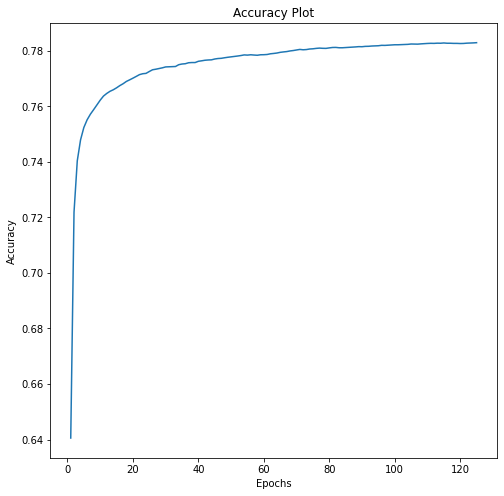

In [ ]:
acc_plot("/content/classifier_logs_XLM_Roberta/"+log_files[0])

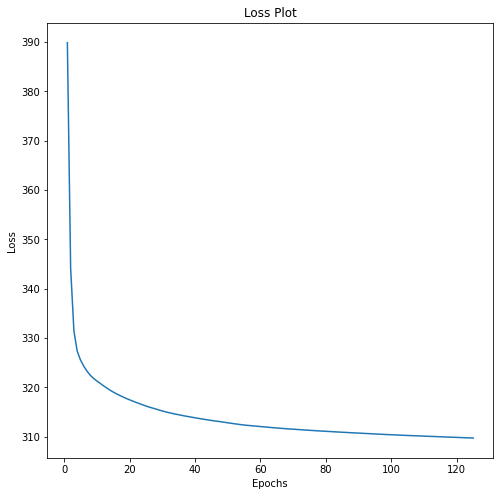

In [ ]:
loss_plot("/content/classifier_logs_XLM_Roberta/"+log_files[0])

##9. Evaluate Trained Model on Test Data

In [ ]:
preds = mutli_lingual_model_XLM_Roberta.transform(test_df)
preds.show()

+------+---------------------------------+--------+--------------------+--------------------+--------------------+
|   _c0|                             text|       y|            document| sentence_embeddings|               class|
+------+---------------------------------+--------+--------------------+--------------------+--------------------+
|800000|케빈의 연기력도 허접한 감독의 ...|negative|[[document, 0, 30...|[[sentence_embedd...|[[category, 0, 30...|
|800001|            roki79@nate.com 기...|positive|[[document, 0, 64...|[[sentence_embedd...|[[category, 0, 64...|
|800002|             Se aprendem a faz...|positive|[[document, 0, 19...|[[sentence_embedd...|[[category, 0, 19...|
|800003|             @little_bluebit n...|negative|[[document, 0, 71...|[[sentence_embedd...|[[category, 0, 71...|
|800004|             Quem se sente inc...|positive|[[document, 0, 37...|[[sentence_embedd...|[[category, 0, 37...|
|800005|             eheheh hoje vou e...|positive|[[document, 0, 69...|[[sentence_embedd...|[

In [ ]:
df = preds.select(['y','class.result']).toPandas()
df['result'] = df['result'].apply(lambda x : x[0])
df

,y,result
0,negative,positive
1,positive,positive
2,positive,positive
3,negative,negative
4,positive,positive
...,...,...
6995,negative,negative
6996,negative,negative
6997,positive,positive
6998,positive,positive


In [ ]:

# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report
print(classification_report(df['result'], df['y']))

              precision    recall  f1-score   support

    negative       0.73      0.80      0.76      3212
    positive       0.81      0.75      0.78      3788

    accuracy                           0.77      7000
   macro avg       0.77      0.77      0.77      7000
weighted avg       0.77      0.77      0.77      7000



In [ ]:


from sklearn.metrics import f1_score,precision_score,accuracy_score
XLM_Roberta_f1= f1_score(df['result'], df['y'], average='macro')
XLM_Roberta_precision = precision_score(df['result'], df['y'], average='macro')
print(XLM_Roberta_f1, XLM_Roberta_precision)


0.7710517132036767 0.7714759464175627


##10. Comparing Performance 

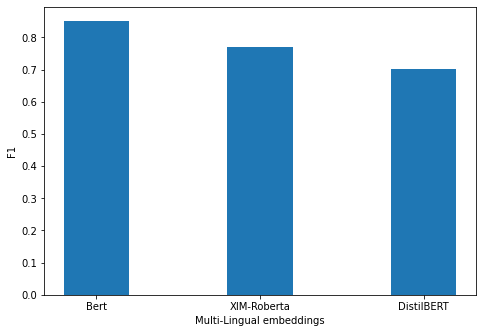

In [2]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
embeddings = ['Bert', 'XlM-Roberta', 'DistilBERT']
f1 = [0.8522857142857143 ,0.7710517132036767,0.7018481007344232 ]
ax.bar(embeddings,f1,width =.4)
plt.xlabel("Multi-Lingual embeddings")
plt.ylabel("F1")

plt.show()

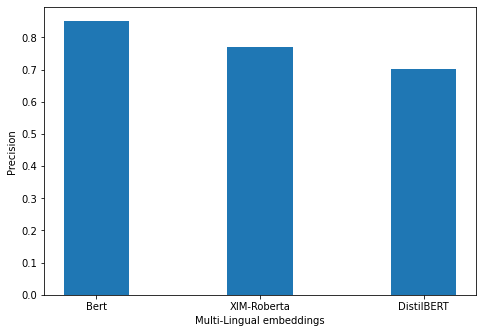

In [3]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
embeddings = ['Bert', 'XlM-Roberta', 'DistilBERT']
Percision = [0.8522868274766726 ,0.7714759464175627,0.7019751209470968 ]
ax.bar(embeddings,f1,width =.4)
plt.xlabel("Multi-Lingual embeddings")
plt.ylabel("Precision")

plt.show()

##11. Saving the best performing Model

In [ ]:
mutli_lingual_model.stages[-1].write().overwrite().save('/content/tmp_multi_classifierDL_model')


##12. Loading Saved Model

In [ ]:
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from pyspark.sql import SparkSession

document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
sent_embeddings = BertSentenceEmbeddings.pretrained("sent_bert_use_cmlm_multi_base_br", "xx") \
      .setInputCols("document") \
      .setOutputCol("sentence_embeddings")
classifierDl = ClassifierDLModel.load('/content/tmp_multi_classifierDL_model')\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")
pipeline = Pipeline(
    stages = [
        document,
        sent_embeddings,
        classifierDl
    ])
empty_df = spark.createDataFrame([['']]).toDF('text')
mutli_lingual_model = pipeline.fit(empty_df)

mutli_lingual_model = LightPipeline(mutli_lingual_model)


sent_bert_use_cmlm_multi_base_br download started this may take some time.
Approximate size to download 1.7 GB
[OK!]


#### The Model understands Englsih
![en](https://www.worldometers.info/img/flags/small/tn_nz-flag.gif)

In [ ]:
mutli_lingual_model.annotate("This was awful!")

{'class': ['negative'],
 'document': ['This was awful!'],
 'sentence_embeddings': ['This was awful!']}

In [ ]:
mutli_lingual_model.annotate("This was great!")

{'class': ['positive'],
 'document': ['This was great!'],
 'sentence_embeddings': ['This was great!']}

#### The Model understands German
![de](https://www.worldometers.info/img/flags/small/tn_gm-flag.gif)

In [ ]:
# German for:' this movie was great!'
mutli_lingual_model.annotate("Der Film war echt klasse!")

{'class': ['positive'],
 'document': ['Der Film war echt klasse!'],
 'sentence_embeddings': ['Der Film war echt klasse!']}

In [ ]:
# German for: 'This movie was really boring'
mutli_lingual_model.annotate("Der Film war echt langweilig!")

{'class': ['negative'],
 'document': ['Der Film war echt langweilig!'],
 'sentence_embeddings': ['Der Film war echt langweilig!']}

#### The Model understands Chinese
![zh](https://www.worldometers.info/img/flags/small/tn_ch-flag.gif)

In [ ]:
# Chinese for: "This model was awful!"
mutli_lingual_model.annotate("这部电影太糟糕了！")

{'class': ['negative'],
 'document': ['这部电影太糟糕了！'],
 'sentence_embeddings': ['这部电影太糟糕了！']}

In [ ]:
# Chine for : "This move was great!"
mutli_lingual_model.annotate("此举很棒！")


{'class': ['positive'],
 'document': ['此举很棒！'],
 'sentence_embeddings': ['此举很棒！']}

#### The model understands Vietnamese
![vi](https://www.worldometers.info/img/flags/small/tn_vm-flag.gif)

In [ ]:
# Vietnamese for : 'The movie was painful to watch'
mutli_lingual_model.annotate('Phim đau điếng người xem')


{'class': ['negative'],
 'document': ['Phim đau điếng người xem'],
 'sentence_embeddings': ['Phim đau điếng người xem']}

In [ ]:

# Vietnamese for : 'This was the best movie ever'
mutli_lingual_model.annotate('Đây là bộ phim hay nhất từ ​​trước đến nay')

{'class': ['positive'],
 'document': ['Đây là bộ phim hay nhất từ \u200b\u200btrước đến nay'],
 'sentence_embeddings': ['Đây là bộ phim hay nhất từ \u200b\u200btrước đến nay']}

#### The model understands Japanese
![ja](https://www.worldometers.info/img/flags/small/tn_ja-flag.gif)


In [ ]:

# Japanese for : 'This is now my favorite movie!'
mutli_lingual_model.annotate('これが私のお気に入りの映画です！')

{'class': ['positive'],
 'document': ['これが私のお気に入りの映画です！'],
 'sentence_embeddings': ['これが私のお気に入りの映画です！']}

In [ ]:

# Japanese for : 'I would rather kill myself than watch that movie again'
mutli_lingual_model.annotate('その映画をもう一度見るよりも自殺したい')

{'class': ['negative'],
 'document': ['その映画をもう一度見るよりも自殺したい'],
 'sentence_embeddings': ['その映画をもう一度見るよりも自殺したい']}

#### The model understands Zulu
![zu](https://www.worldometers.info/img/flags/small/tn_sf-flag.gif)

In [ ]:
# Zulu for : 'Bitcoin went up by 50 percent !!!'
mutli_lingual_model.annotate('I-Bitcoin inyuke ngamaphesenti ama-50 !!!')


{'class': ['negative'],
 'document': ['I-Bitcoin inyuke ngamaphesenti ama-50 !!!'],
 'sentence_embeddings': ['I-Bitcoin inyuke ngamaphesenti ama-50 !!!']}

In [ ]:
# Zulu for : 'The whole crypto system crashed!!! '
mutli_lingual_model.annotate('Lonke uhlelo lwe-crypto luphahlazeka !!!')


{'class': ['negative'],
 'document': ['Lonke uhlelo lwe-crypto luphahlazeka !!!'],
 'sentence_embeddings': ['Lonke uhlelo lwe-crypto luphahlazeka !!!']}

#### The  Model understands Turkish
![tr](https://www.worldometers.info/img/flags/small/tn_tu-flag.gif)

In [ ]:
# Turkish for : 'Bitcoin dropped by 50 percent !!!'
mutli_lingual_model.annotate('Bitcoin yüzde 50 düştü !!! ')

{'class': ['negative'],
 'document': ['Bitcoin yüzde 50 düştü !!! '],
 'sentence_embeddings': ['Bitcoin yüzde 50 düştü !!! ']}

In [ ]:
# Turkish for : 'Bitcoin went up by 50 percent !!!'
mutli_lingual_model.annotate('Bitcoin yüzde 50 arttı !!!')



{'class': ['negative'],
 'document': ['Bitcoin yüzde 50 arttı !!!'],
 'sentence_embeddings': ['Bitcoin yüzde 50 arttı !!!']}

#### The Model understands French
![fr](https://www.worldometers.info/img/flags/small/tn_fr-flag.gif)

In [ ]:
# French for : 'Bitcoin dropped by 50 percent !!!'
mutli_lingual_model.annotate("Bitcoin a chuté de 50% !!! ")

{'class': ['negative'],
 'document': ['Bitcoin a chuté de 50% !!! '],
 'sentence_embeddings': ['Bitcoin a chuté de 50% !!! ']}

In [ ]:
# French for : 'Bitcoin went up by 50 percent !!!'
mutli_lingual_model.annotate("Le Bitcoin a augmenté de 50% !!! ")

{'class': ['positive'],
 'document': ['Le Bitcoin a augmenté de 50% !!! '],
 'sentence_embeddings': ['Le Bitcoin a augmenté de 50% !!! ']}